# Emotion Classification
Dataset:
https://www.kaggle.com/ishantjuyal/emotions-in-text

In [43]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [44]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, Bidirectional, GRU
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [45]:
df=pd.read_csv('Emotion_final.csv') #Text data
EMBEDDING_FILE= f'glove.6B.100d.txt' #GloVe file path
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


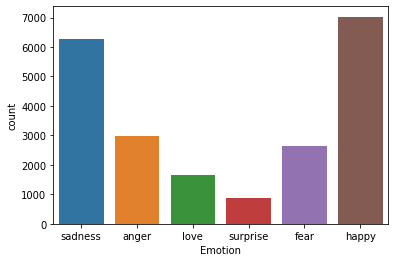

In [46]:
sns.countplot(df['Emotion']) 

In [47]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Input
y=df['Emotion'] #Output

In [48]:
messages=X.copy()
messages.reset_index(inplace=True)

In [49]:
ps = PorterStemmer()
# sno = nltk.stem.SnowballStemmer('english')
lemma = nltk.wordnet.WordNetLemmatizer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case
    review = review.split()
    # review = [lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

## Embedding layer using GloVe

In [50]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf-8'))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [51]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: 
        continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [52]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

10000

In [53]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2005 8512 3406]
 [   0    0    0 ... 7448 6744  543]
 [   0    0    0 ... 8512 4547 2846]
 ...
 [   0    0    0 ... 8611 8275 6059]
 [   0    0    0 ... 7854 6059  889]
 [   0    0    0 ...    0 6059 7125]]


In [54]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [55]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [56]:
#Train-Test split
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1, random_state=21) 

## Modeling

In [14]:
activation = ['softmax', 'relu', 'tanh', 'sigmoid']
optimizer = ['RMSprop','Adadelta', 'Adam', 'Adamax']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(activation=activation, batch_size=batch_size, epochs=epochs)

Website for Grid Search: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [15]:
def create_model(activation = 'relu', optimizer = 'Adam'):

    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(10, input_dim=x_train.shape[1],
                    activation=activation,
                    kernel_initializer='normal'))
    model.add(Dense(6, activation='softmax',
                    kernel_initializer='normal'))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  # here we add a regulizer normalization function from Talos
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [16]:
my_model_history = KerasClassifier(build_fn= create_model,  epochs=100, batch_size=10, verbose=0)


In [17]:
grid = GridSearchCV(estimator=my_model_history, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_final, y_final)


Using TensorFlow backend.
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/harukageorge/opt

2022-04-26 21:29:06.721128: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-26 21:29:06.730005: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-26 21:29:06.737444: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-26 21:29:06.740638: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-04-26 22:33:46.002491: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [18]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.331283 using {'activation': 'tanh', 'batch_size': 10, 'epochs': 100}
0.327648 (0.013612) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 10}
0.327555 (0.013558) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 50}
0.327695 (0.013665) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 100}
0.327135 (0.013259) with: {'activation': 'softmax', 'batch_size': 20, 'epochs': 10}
0.327555 (0.013558) with: {'activation': 'softmax', 'batch_size': 20, 'epochs': 50}
0.329326 (0.014997) with: {'activation': 'softmax', 'batch_size': 20, 'epochs': 100}
0.327648 (0.014105) with: {'activation': 'softmax', 'batch_size': 40, 'epochs': 10}
0.327042 (0.013205) with: {'activation': 'softmax', 'batch_size': 40, 'epochs': 50}
0.327555 (0.013558) with: {'activation': 'softmax', 'batch_size': 40, 'epochs': 100}
0.327555 (0.013558) with: {'activation': 'softmax', 'batch_size': 60, 'epochs': 10}
0.327741 (0.013294) with: {'activation': 'softmax', 'batch_size': 60, 'epochs': 

Training for fold 1 ...
Train on 17167 samples, validate on 4292 samples
Epoch 1/100
17167/17167 [==============================] - 11s 633us/step - loss: 1.6691 - accuracy: 0.2972 - val_loss: 1.6140 - val_accuracy: 0.3145
Epoch 2/100
17167/17167 [==============================] - 8s 486us/step - loss: 1.5888 - accuracy: 0.3239 - val_loss: 1.6048 - val_accuracy: 0.3136
Epoch 3/100
17167/17167 [==============================] - 9s 498us/step - loss: 1.5847 - accuracy: 0.3274 - val_loss: 1.6027 - val_accuracy: 0.3276
Epoch 4/100
17167/17167 [==============================] - 8s 478us/step - loss: 1.5830 - accuracy: 0.3296 - val_loss: 1.6003 - val_accuracy: 0.3290
Epoch 5/100
17167/17167 [==============================] - 9s 546us/step - loss: 1.5824 - accuracy: 0.3307 - val_loss: 1.6034 - val_accuracy: 0.3262
Epoch 6/100
17167/17167 [==============================] - 6s 378us/step - loss: 1.5826 - accuracy: 0.3290 - val_loss: 1.6010 - val_accuracy: 0.3278
Epoch 7/100
17167/17167 [=======

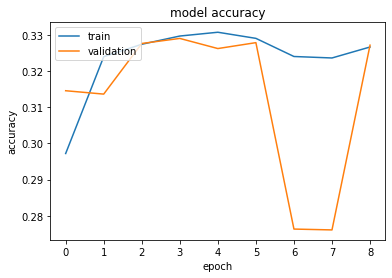

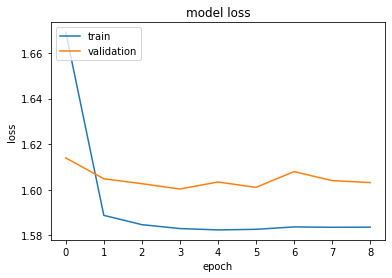

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


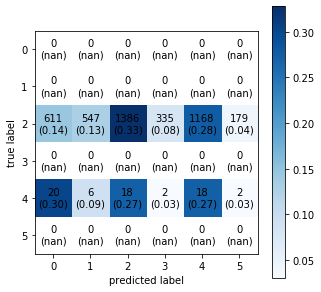

Training for fold 2 ...
Train on 17167 samples, validate on 4292 samples
Epoch 1/100
17167/17167 [==============================] - 4s 237us/step - loss: 1.6886 - accuracy: 0.2981 - val_loss: 1.5821 - val_accuracy: 0.3131
Epoch 2/100
17167/17167 [==============================] - 4s 241us/step - loss: 1.5969 - accuracy: 0.3221 - val_loss: 1.5702 - val_accuracy: 0.3239
Epoch 3/100
17167/17167 [==============================] - 4s 231us/step - loss: 1.5924 - accuracy: 0.3264 - val_loss: 1.5675 - val_accuracy: 0.3278
Epoch 4/100
17167/17167 [==============================] - 4s 212us/step - loss: 1.5912 - accuracy: 0.3245 - val_loss: 1.5687 - val_accuracy: 0.3274
Epoch 5/100
17167/17167 [==============================] - 4s 214us/step - loss: 1.5902 - accuracy: 0.3275 - val_loss: 1.5688 - val_accuracy: 0.3274
Epoch 6/100
17167/17167 [==============================] - 4s 214us/step - loss: 1.5907 - accuracy: 0.3234 - val_loss: 1.5684 - val_accuracy: 0.3269
Epoch 7/100
17167/17167 [========

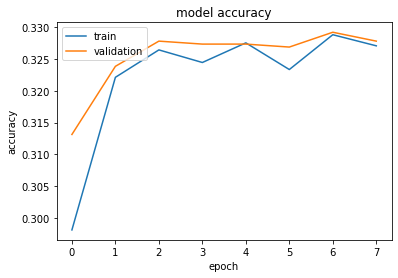

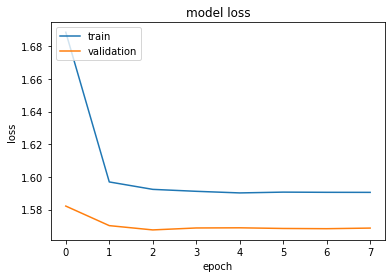

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


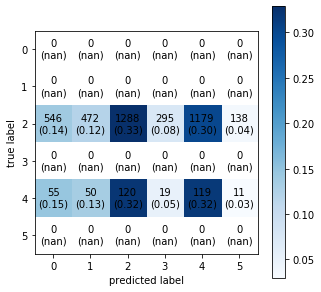

Training for fold 3 ...
Train on 17167 samples, validate on 4292 samples
Epoch 1/100
17167/17167 [==============================] - 4s 236us/step - loss: 1.7024 - accuracy: 0.3017 - val_loss: 1.6024 - val_accuracy: 0.3315
Epoch 2/100
17167/17167 [==============================] - 4s 212us/step - loss: 1.5944 - accuracy: 0.3231 - val_loss: 1.5928 - val_accuracy: 0.3199
Epoch 3/100
17167/17167 [==============================] - 3s 172us/step - loss: 1.5907 - accuracy: 0.3225 - val_loss: 1.5889 - val_accuracy: 0.3350
Epoch 4/100
17167/17167 [==============================] - 3s 176us/step - loss: 1.5889 - accuracy: 0.3221 - val_loss: 1.5882 - val_accuracy: 0.3343
Epoch 5/100
17167/17167 [==============================] - 3s 187us/step - loss: 1.5893 - accuracy: 0.3234 - val_loss: 1.5836 - val_accuracy: 0.3255
Epoch 6/100
17167/17167 [==============================] - 3s 169us/step - loss: 1.5873 - accuracy: 0.3239 - val_loss: 1.5834 - val_accuracy: 0.3257
Epoch 7/100
17167/17167 [========

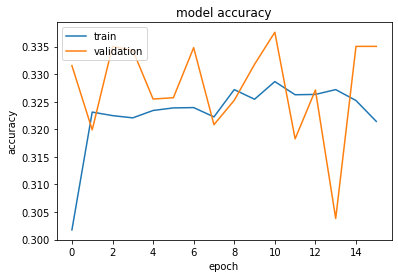

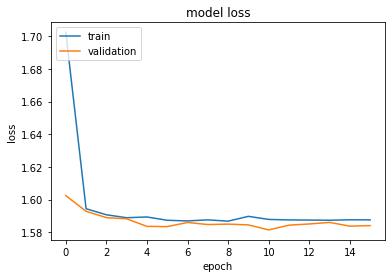

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


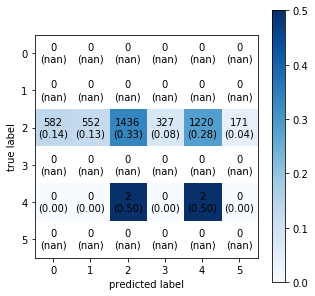

Training for fold 4 ...
Train on 17167 samples, validate on 4292 samples
Epoch 1/100
17167/17167 [==============================] - 3s 194us/step - loss: 1.6820 - accuracy: 0.3031 - val_loss: 1.5942 - val_accuracy: 0.3227
Epoch 2/100
17167/17167 [==============================] - 3s 181us/step - loss: 1.5970 - accuracy: 0.3234 - val_loss: 1.5871 - val_accuracy: 0.3283
Epoch 3/100
17167/17167 [==============================] - 3s 185us/step - loss: 1.5947 - accuracy: 0.3162 - val_loss: 1.5872 - val_accuracy: 0.3099
Epoch 4/100
17167/17167 [==============================] - 3s 162us/step - loss: 1.5883 - accuracy: 0.3215 - val_loss: 1.5830 - val_accuracy: 0.3239
Epoch 5/100
17167/17167 [==============================] - 3s 174us/step - loss: 1.5872 - accuracy: 0.3259 - val_loss: 1.5803 - val_accuracy: 0.3299
Epoch 6/100
17167/17167 [==============================] - 3s 180us/step - loss: 1.5870 - accuracy: 0.3228 - val_loss: 1.5816 - val_accuracy: 0.3276
Epoch 7/100
17167/17167 [========

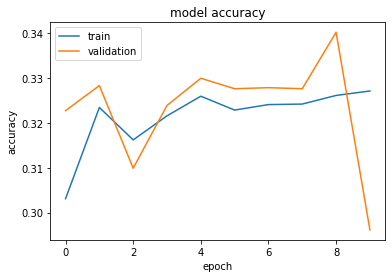

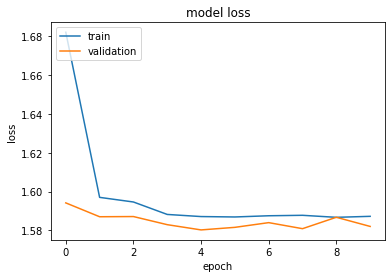

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


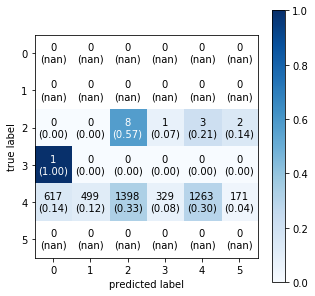

Training for fold 5 ...
Train on 17168 samples, validate on 4291 samples
Epoch 1/100
17168/17168 [==============================] - 4s 240us/step - loss: 1.6850 - accuracy: 0.3061 - val_loss: 1.6042 - val_accuracy: 0.3132
Epoch 2/100
17168/17168 [==============================] - 3s 197us/step - loss: 1.5884 - accuracy: 0.3228 - val_loss: 1.5960 - val_accuracy: 0.3193
Epoch 3/100
17168/17168 [==============================] - 4s 220us/step - loss: 1.5908 - accuracy: 0.3202 - val_loss: 1.6155 - val_accuracy: 0.3183
Epoch 4/100
17168/17168 [==============================] - 3s 197us/step - loss: 1.5934 - accuracy: 0.3240 - val_loss: 1.5996 - val_accuracy: 0.3190
Epoch 5/100
17168/17168 [==============================] - 3s 168us/step - loss: 1.5854 - accuracy: 0.3286 - val_loss: 1.5980 - val_accuracy: 0.3193
Epoch 6/100
17168/17168 [==============================] - 3s 195us/step - loss: 1.5843 - accuracy: 0.3296 - val_loss: 1.5951 - val_accuracy: 0.3195
Epoch 7/100
17168/17168 [========

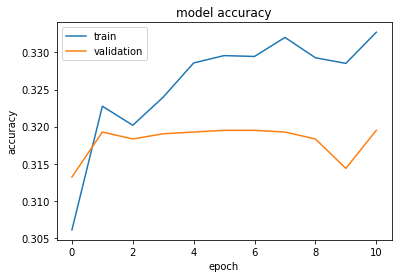

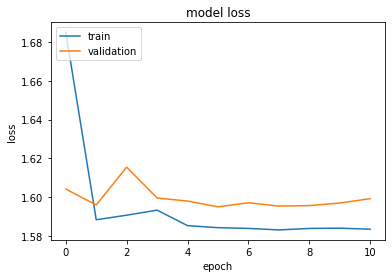

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


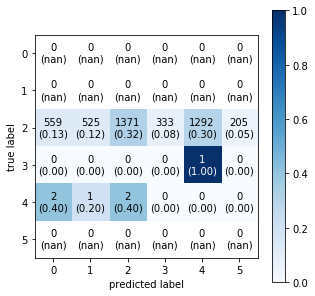

In [57]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
import tensorflow as tf


from keras.callbacks import EarlyStopping
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold=[]
loss_per_fold=[]
for train, test in kfold.split(X_final, y_final):
    model = Sequential()
    model.add(Dense(10, input_dim=X_final[train].shape[1],
                    activation='tanh',
                    kernel_initializer='normal'))
    
    model.add(Dense(6, activation='softmax'))
    #compiling model
    model.compile(optimizer= 'adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(f'Training for fold {fold_no} ...')
                    
    #fit the data to model
    hist = model.fit(X_final[train], y_final[train],
                     epochs=100,
                     batch_size=10,
                    validation_data=(X_final[test], y_final[test]),
                     verbose=1,
                    callbacks=[EarlyStop])
     # Generate generalization metrics
    scores = model.evaluate(X_final[test], y_final[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])    
 #   print(hist.history.keys())
 #  "Accuracy"
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    pred=model.predict(X_final[test])
    classes_x=np.argmax(pred,axis=1)
    #Accuracy score
    #print('Accuracy score'accuracy_score(classes_x, y[test]))
    
    #Confusion Matrix
    print('Confusion Matrix')
    cm = (confusion_matrix(classes_x, y_final[test]))
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5,5),
    show_absolute = True,
    show_normed = True,
    colorbar = True)
    plt.show()
    #print(classification_report(p, test_y))
    
 # Increase fold number
    fold_no = fold_no + 1